In [1]:
import os
from dotenv import load_dotenv

from pathlib import Path
import sys

PATH_PROJECT_ROOT_DIR = Path(os.getcwd()).resolve().parent
PATH_SRC_DIR = os.path.join(PATH_PROJECT_ROOT_DIR, "src/")

sys.path.append(str(PATH_SRC_DIR))

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from wordcloud import WordCloud

## ML modules
# Hugging face imports
from huggingface_hub import login
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, pipeline,Trainer, TrainingArguments,AutoConfig)
from datasets import Dataset, DatasetDict

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


# Utils
from utils import clean_text


In [3]:
input_tw = pd.read_parquet("data/train-00000-of-00001.parquet")

# Quick EDA
print("Shape:", input_tw.shape)
print("\nColumns:", input_tw.columns.tolist())
print("\nMissing values:\n", input_tw.isnull().sum())
print("\nSentiment value counts:\n", input_tw['sentiment'].value_counts())
print("\nTweet length stats:\n", input_tw['tweet'].apply(len).describe())
input_tw.head(5)

Shape: (38091, 3)

Columns: ['tweet', 'sentiment', 'url']

Missing values:
 tweet        0
sentiment    0
url          0
dtype: int64

Sentiment value counts:
 sentiment
1    17368
0    12181
2     8542
Name: count, dtype: int64

Tweet length stats:
 count    38091.000000
mean        95.323751
std         72.693280
min          1.000000
25%         55.000000
50%         84.000000
75%        131.000000
max       4229.000000
Name: tweet, dtype: float64


,tweet,sentiment,url
0,$BYND - JPMorgan reels in expectations on Beyo...,2,https://huggingface.co/datasets/zeroshot/twitt...
1,$CCL $RCL - Nomura points to bookings weakness...,2,https://huggingface.co/datasets/zeroshot/twitt...
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",2,https://huggingface.co/datasets/zeroshot/twitt...
3,$ESS: BTIG Research cuts to Neutral https://t....,2,https://huggingface.co/datasets/zeroshot/twitt...
4,$FNKO - Funko slides after Piper Jaffray PT cu...,2,https://huggingface.co/datasets/zeroshot/twitt...


/tmp/ipykernel_918538/1315524807.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax_box.boxplot(data, patch_artist=True, labels=labels, showmeans=True, meanline=False)


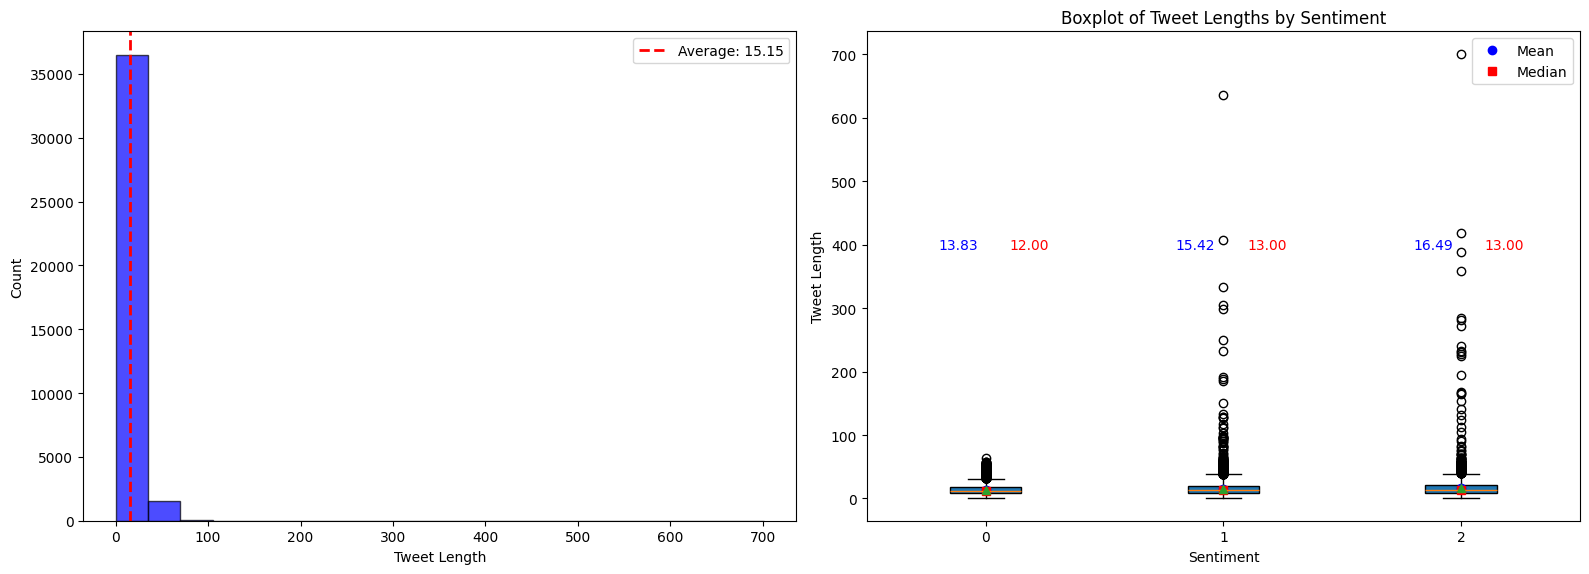

In [4]:

# Calculate tweet lengths
input_tw['tweet_length'] = input_tw['tweet'].str.split().str.len()
text_lengths = input_tw['tweet_length']
average_length = np.mean(text_lengths)

# Prepare data grouped by sentiment
grouped = input_tw.groupby('sentiment')['tweet_length']
data = [grouped.get_group(sent) for sent in grouped.groups]
labels = list(grouped.groups.keys())

# Create subplot: histogram + customized boxplot
fig, (ax_hist, ax_box) = plt.subplots(1, 2, figsize=(16, 6))

# Histogram
ax_hist.hist(text_lengths, bins=20, color="blue", edgecolor="black", alpha=0.7)
ax_hist.axvline(average_length, color='red', linestyle='dashed', linewidth=2, label=f'Average: {average_length:.2f}')
ax_hist.set_xlabel('Tweet Length')
ax_hist.set_ylabel('Count')
ax_hist.legend()

# Boxplot with custom mean and median
box = ax_box.boxplot(data, patch_artist=True, labels=labels, showmeans=True, meanline=False)

# Add mean and median markers and annotate their values
for i, group_data in enumerate(data, start=1):
    mean_val = np.mean(group_data)
    median_val = np.median(group_data)
    
    # Plot markers
    ax_box.plot(i, mean_val, 'o', color='blue', label='Mean' if i == 1 else "")
    ax_box.plot(i, median_val, 's', color='red', label='Median' if i == 1 else "")
    
    # Add text annotations
    ax_box.text(i - 0.2, 400, f'{mean_val:.2f}', color='blue', va='center')
    ax_box.text(i + 0.1, 400, f'{median_val:.2f}', color='red', va='center')

# Avoid duplicate legend entries
handles, labels = ax_box.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax_box.legend(by_label.values(), by_label.keys())

ax_box.set_title('Boxplot of Tweet Lengths by Sentiment')
ax_box.set_xlabel('Sentiment')
ax_box.set_ylabel('Tweet Length')
fig.suptitle('')  # Remove pandas-style title

plt.tight_layout()
plt.show()


In [5]:
df_tw = input_tw[['tweet', 'sentiment']].rename(columns={'sentiment': 'label'})
df_tw['tweet'] = df_tw['tweet'].apply(clean_text)

(np.float64(-0.5), np.float64(399.5), np.float64(199.5), np.float64(-0.5))

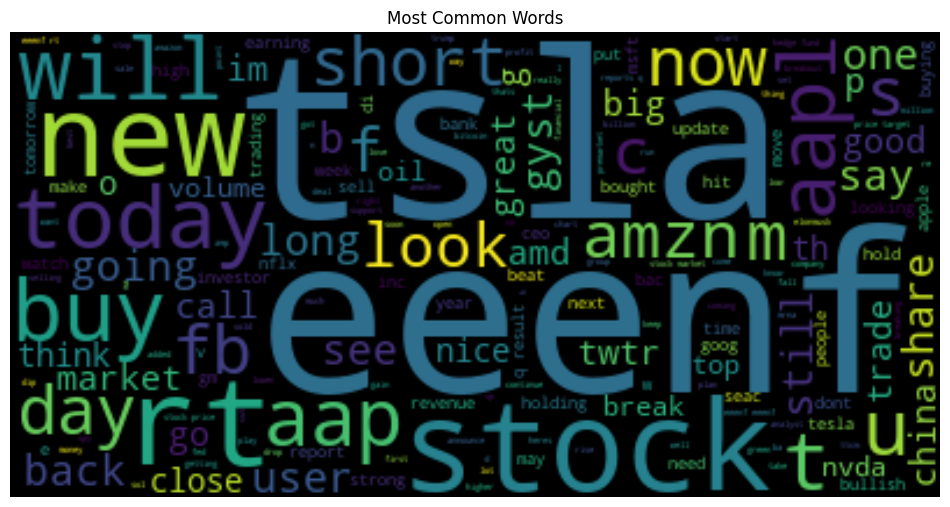

In [6]:
text_raw = df_tw['tweet'].to_string()
wordcloud = WordCloud().generate(text_raw)
plt.figure(figsize=(12,8))
plt.imshow(wordcloud,interpolation='bilinear')
plt.title('Most Common Words')
plt.axis("off")

In [7]:
# Point to your internal certificate
os.environ["REQUESTS_CA_BUNDLE"] = "/etc/pki/tls/certs/sanofi-ca.crt"
token = os.getenv("TOKEN_HF")
if not token:
    raise ValueError("TOKEN_HF environment variable is not set. Please set it in your .env file.")
login(token=token)


In [8]:
models = [
    "ProsusAI/finbert",
    "StephanAkkerman/FinTwitBERT-sentiment",
    "yiyanghkust/finbert-tone"
]  


# Different models have different label mappings, so we need to handle them accordingly
for model_id in models:    
    config = AutoConfig.from_pretrained(model_id)
    print(model_id, config.label2id)


ProsusAI/finbert {'positive': 0, 'negative': 1, 'neutral': 2}
StephanAkkerman/FinTwitBERT-sentiment {'BEARISH': 2, 'BULLISH': 1, 'NEUTRAL': 0}
yiyanghkust/finbert-tone {'Positive': 1, 'Negative': 2, 'Neutral': 0}


In [21]:

sampled_df = input_tw.sample(10000, random_state=32).reset_index(drop=True)

sentiment_map = {'negative': 0, 'positive': 1, 'neutral': 2}

for model_name in models:
    
    # Set up the model and tokenizer
    # Map the label properly
    cfg = AutoConfig.from_pretrained(model_name)
    cfg.id2label   = {0: "negative", 1: "positive", 2: "neutral"}
    cfg.label2id   = {v: k for k, v in cfg.id2label.items()}
    cfg.num_labels = 3

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model     = AutoModelForSequenceClassification.from_pretrained(
                    model_name,
                    config=cfg
                )

    clf = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

    # Run the model
    res = pd.DataFrame(clf(sampled_df['tweet'].tolist(), truncation=True))

    res['label_norm'] = res['label'].str.lower()
    res['predicted']  = res['label_norm'].map(sentiment_map)

    # Compute the accuracy and the confusion matrix
    true_nums = sampled_df['sentiment']
    acc       = (res['predicted'] == true_nums).mean()

    cm = pd.crosstab(
        true_nums.map({0:"negative",1:"positive",2:"neutral"}),
        res['label_norm'],
        rownames=['Actual'], colnames=['Predicted'], dropna=False
    )

    print(f"\n=== {model_name} ===")
    print("Confusion matrix:\n", cm)
    print(f"Accuracy: {acc:.2%}")


Device set to use cpu



=== ProsusAI/finbert ===
Confusion matrix:
 Predicted  negative  neutral  positive
Actual                                
negative        311     2579       325
neutral         135     1141       920
positive       1217     3107       265
Accuracy: 17.17%


Device set to use cpu
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



=== StephanAkkerman/FinTwitBERT-sentiment ===
Confusion matrix:
 Predicted  negative  neutral  positive
Actual                                
negative       2467      307       441
neutral          57     1994       145
positive        237      448      3904
Accuracy: 83.65%


Device set to use cpu
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



=== yiyanghkust/finbert-tone ===
Confusion matrix:
 Predicted  negative  neutral  positive
Actual                                
negative       2800      157       258
neutral        1499      552       145
positive       3204      109      1276
Accuracy: 46.28%


In [57]:
# FintweetBERT results
data = {
    "negative": [2467, 57, 237],
    "neutral":  [307, 1994, 448],
    "positive": [441, 145, 3904],
}

index = ["negative", "neutral", "positive"]
df_cm = pd.DataFrame(data, index=index)
df_cm.index.name = "Actual"
df_cm.columns.name = "Predicted"



In [58]:
# 1) True positives (TP) for each class:
tp = np.diag(df_cm)

# 2) False positives: sum of column minus TP
fp = df_cm.sum(axis=0) - tp

# 3) False negatives: sum of row minus TP
fn = df_cm.sum(axis=1) - tp

# 4) Precision and recall per class
precision = tp / (tp + fp)
recall    = tp / (tp + fn)

# 5) F1 per class (handle zero‑division gracefully)
f1 = 2 * precision * recall / (precision + recall)

# 6) Macro‑F1: unweighted mean across classes
macro_f1 = np.nanmean(f1)

print("Per‑class precision:", precision)
print("Per‑class recall:   ", recall)
print("Per‑class F1:       ", f1)
print("Macro‑F1:           ", macro_f1)

Per‑class precision: Predicted
negative    0.893517
neutral     0.725355
positive    0.869488
dtype: float64
Per‑class recall:    Actual
negative    0.767341
neutral     0.908015
positive    0.850730
dtype: float64
Per‑class F1:        Predicted
negative    0.825636
neutral     0.806471
positive    0.860007
dtype: float64
Macro‑F1:            0.8307045561703937


In [10]:
input_tw

,tweet,sentiment,url,tweet_length
0,$BYND - JPMorgan reels in expectations on Beyo...,2,https://huggingface.co/datasets/zeroshot/twitt...,10
1,$CCL $RCL - Nomura points to bookings weakness...,2,https://huggingface.co/datasets/zeroshot/twitt...,14
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",2,https://huggingface.co/datasets/zeroshot/twitt...,14
3,$ESS: BTIG Research cuts to Neutral https://t....,2,https://huggingface.co/datasets/zeroshot/twitt...,7
4,$FNKO - Funko slides after Piper Jaffray PT cu...,2,https://huggingface.co/datasets/zeroshot/twitt...,10
...,...,...,...,...
38086,Facebook $FB received a Buy rating from Wells ...,1,https://huggingface.co/datasets/ChanceFocus/fi...,16
38087,$TSLA Wish had my puts back but see if we can ...,2,https://huggingface.co/datasets/ChanceFocus/fi...,26
38088,Citrix Systems Inc $CTXS Position Increased by...,1,https://huggingface.co/datasets/ChanceFocus/fi...,10
38089,Notable gainers among liquid option names this...,1,https://huggingface.co/datasets/ChanceFocus/fi...,20


,tweet,sentiment,url,tweet_length
0,Let's do this $EEENF https://t.co/M2UzoQdEyG,1,https://www.kaggle.com/datasets/mattgilgo/stoc...,5
1,Saint-Gobain North America Announces Largest R...,1,https://huggingface.co/datasets/zeroshot/twitt...,12
2,Pokémon Go generated $4 billion in revenue for...,1,https://github.com/moritzwilksch/MasterThesis/...,20
3,you want to put your money there? \n,2,https://github.com/poojathakoor/twitter-stock-...,7
4,$FB is going to give us good azz earnings.\n,1,https://github.com/poojathakoor/twitter-stock-...,9
...,...,...,...,...
4995,Expect2win stocks\n $COIN $FB \n#bitcoin @FIN...,0,https://github.com/moritzwilksch/MasterThesis/...,11
4996,WMT opening range 30 min. JPM comments negativ...,2,https://www.kaggle.com/datasets/yash612/stockm...,10
4997,Keeping and eye on $RBLX $AAPL $DIS to possibl...,1,https://github.com/moritzwilksch/MasterThesis/...,20
4998,Why Shake Shack Stock Gained 13% in January,1,https://huggingface.co/datasets/zeroshot/twitt...,8


In [ ]:
sampled_df2 = input_tw.sample(5000, random_state=50).reset_index(drop=True)

# 2. Prepare data
df_full = sampled_df2.rename(columns={'tweet':'text', 'sentiment':'label'})
train_df, test_df = train_test_split(
    df_full, test_size=0.2, random_state=1, stratify=df_full['label']
)
dataset = DatasetDict({
    'train': Dataset.from_pandas(train_df.reset_index(drop=True)),
    'test':  Dataset.from_pandas(test_df.reset_index(drop=True))
})

# 3. Tokenizer + preprocessing
model_name = "StephanAkkerman/FinTwitBERT-sentiment"
tokenizer  = AutoTokenizer.from_pretrained(model_name)
def model_init():
    cfg = AutoConfig.from_pretrained(model_name)
    cfg.id2label = {0: "negative", 1: "positive", 2: "neutral"}  # adjust if needed
    cfg.label2id = {v: k for k, v in cfg.id2label.items()}
    cfg.num_labels = 3
    return AutoModelForSequenceClassification.from_pretrained(model_name, config=cfg)

def preprocess(batch):
    return tokenizer(batch['text'], truncation=True, padding='max_length', max_length=128)

dataset = dataset.map(preprocess, batched=True)
dataset = dataset.rename_column('label','labels')
dataset = dataset.remove_columns(['text'])
dataset.set_format('torch')

# 4. Metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)
    return {'accuracy': acc, 'precision': p, 'recall': r, 'f1': f1}

# 5. Model‑init function for hyperparameter search
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# 6. Base training args
base_args = TrainingArguments(
    output_dir='./optuna_fintwitbert',
    eval_strategy='epoch',
    save_strategy='epoch',
    disable_tqdm=True,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    seed=1,
)

trainer = Trainer(
    model_init=model_init,
    args=base_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# 7. Define the search space
def hp_space_optuna(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 5e-5, log=True),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8,16,32]),
        "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.3),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 2, 5),
        "warmup_steps": trial.suggest_categorical("warmup_steps", [0, 100, 200]),
    }

# 8. Run hyperparameter search
best_run = trainer.hyperparameter_search(
    direction="maximize",
    backend="optuna",
    hp_space=hp_space_optuna,
    n_trials=3,                  # number of trials
    compute_objective=lambda metrics: metrics["eval_f1"]
)

print("Best run:", best_run)
# 10. Train!
trainer.train()

# 11. Evaluate on test set
results = trainer.evaluate()
print(results)

# 12. (Optional) Save your fine‑tuned model
trainer.save_model('./finetuned_fintwitbert')

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

/tmp/ipykernel_880902/4079429361.py:52: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
[I 2025-07-19 20:48:06,610] A new study created in memory with name: no-name-de19e136-558f-45bc-ae4d-78ca48276b6e
/home/u1017597/miniconda3/envs/financial_nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.33388203382492065, 'eval_accuracy': 0.875, 'eval_precision': 0.8731884057971014, 'eval_recall': 0.8401875901875901, 'eval_f1': 0.853030303030303, 'eval_runtime': 2.2349, 'eval_samples_per_second': 17.898, 'eval_steps_per_second': 2.237, 'epoch': 1.0}


/home/u1017597/miniconda3/envs/financial_nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.3249876797199249, 'eval_accuracy': 0.875, 'eval_precision': 0.8731884057971014, 'eval_recall': 0.8401875901875901, 'eval_f1': 0.853030303030303, 'eval_runtime': 2.2746, 'eval_samples_per_second': 17.586, 'eval_steps_per_second': 2.198, 'epoch': 2.0}
{'train_runtime': 85.7032, 'train_samples_per_second': 3.734, 'train_steps_per_second': 0.117, 'train_loss': 0.41321454048156736, 'epoch': 2.0}


[I 2025-07-19 20:49:33,751] Trial 0 finished with value: 0.853030303030303 and parameters: {'learning_rate': 3.0453656318198958e-06, 'per_device_train_batch_size': 32, 'weight_decay': 0.22476203410479345, 'num_train_epochs': 2, 'warmup_steps': 100}. Best is trial 0 with value: 0.853030303030303.
/home/u1017597/miniconda3/envs/financial_nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.2835005819797516, 'eval_accuracy': 0.875, 'eval_precision': 0.888888888888889, 'eval_recall': 0.8288239538239538, 'eval_f1': 0.8518518518518517, 'eval_runtime': 2.3474, 'eval_samples_per_second': 17.04, 'eval_steps_per_second': 2.13, 'epoch': 1.0}


/home/u1017597/miniconda3/envs/financial_nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.29445716738700867, 'eval_accuracy': 0.9, 'eval_precision': 0.9466666666666667, 'eval_recall': 0.8446969696969697, 'eval_f1': 0.8782183999575303, 'eval_runtime': 2.3609, 'eval_samples_per_second': 16.943, 'eval_steps_per_second': 2.118, 'epoch': 2.0}


/home/u1017597/miniconda3/envs/financial_nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.29624199867248535, 'eval_accuracy': 0.9, 'eval_precision': 0.9466666666666667, 'eval_recall': 0.8446969696969697, 'eval_f1': 0.8782183999575303, 'eval_runtime': 2.2566, 'eval_samples_per_second': 17.725, 'eval_steps_per_second': 2.216, 'epoch': 3.0}
{'train_runtime': 134.4783, 'train_samples_per_second': 3.569, 'train_steps_per_second': 0.223, 'train_loss': 0.3144891103108724, 'epoch': 3.0}


[I 2025-07-19 20:51:49,690] Trial 1 finished with value: 0.8782183999575303 and parameters: {'learning_rate': 2.0249253515492823e-06, 'per_device_train_batch_size': 16, 'weight_decay': 0.04522440929510718, 'num_train_epochs': 3, 'warmup_steps': 0}. Best is trial 1 with value: 0.8782183999575303.
/home/u1017597/miniconda3/envs/financial_nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.3360397517681122, 'eval_accuracy': 0.875, 'eval_precision': 0.8731884057971014, 'eval_recall': 0.8401875901875901, 'eval_f1': 0.853030303030303, 'eval_runtime': 2.2756, 'eval_samples_per_second': 17.578, 'eval_steps_per_second': 2.197, 'epoch': 1.0}


/home/u1017597/miniconda3/envs/financial_nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.3335334360599518, 'eval_accuracy': 0.875, 'eval_precision': 0.8731884057971014, 'eval_recall': 0.8401875901875901, 'eval_f1': 0.853030303030303, 'eval_runtime': 2.163, 'eval_samples_per_second': 18.492, 'eval_steps_per_second': 2.312, 'epoch': 2.0}
{'train_runtime': 83.2541, 'train_samples_per_second': 3.844, 'train_steps_per_second': 0.12, 'train_loss': 0.4168869495391846, 'epoch': 2.0}


[I 2025-07-19 20:53:14,693] Trial 2 finished with value: 0.853030303030303 and parameters: {'learning_rate': 1.5839636925557163e-06, 'per_device_train_batch_size': 32, 'weight_decay': 0.05197101902009847, 'num_train_epochs': 2, 'warmup_steps': 200}. Best is trial 1 with value: 0.8782183999575303.


Best run: BestRun(run_id='1', objective=0.8782183999575303, hyperparameters={'learning_rate': 2.0249253515492823e-06, 'per_device_train_batch_size': 16, 'weight_decay': 0.04522440929510718, 'num_train_epochs': 3, 'warmup_steps': 0}, run_summary=None)


/home/u1017597/miniconda3/envs/financial_nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.3360397517681122, 'eval_accuracy': 0.875, 'eval_precision': 0.8731884057971014, 'eval_recall': 0.8401875901875901, 'eval_f1': 0.853030303030303, 'eval_runtime': 2.2146, 'eval_samples_per_second': 18.062, 'eval_steps_per_second': 2.258, 'epoch': 1.0}


/home/u1017597/miniconda3/envs/financial_nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.3335334360599518, 'eval_accuracy': 0.875, 'eval_precision': 0.8731884057971014, 'eval_recall': 0.8401875901875901, 'eval_f1': 0.853030303030303, 'eval_runtime': 2.1713, 'eval_samples_per_second': 18.422, 'eval_steps_per_second': 2.303, 'epoch': 2.0}
{'train_runtime': 84.2067, 'train_samples_per_second': 3.8, 'train_steps_per_second': 0.119, 'train_loss': 0.4168869495391846, 'epoch': 2.0}


/home/u1017597/miniconda3/envs/financial_nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.3360397517681122, 'eval_accuracy': 0.875, 'eval_precision': 0.8731884057971014, 'eval_recall': 0.8401875901875901, 'eval_f1': 0.853030303030303, 'eval_runtime': 2.3326, 'eval_samples_per_second': 17.148, 'eval_steps_per_second': 2.144, 'epoch': 2.0}
{'eval_loss': 0.3360397517681122, 'eval_accuracy': 0.875, 'eval_precision': 0.8731884057971014, 'eval_recall': 0.8401875901875901, 'eval_f1': 0.853030303030303, 'eval_runtime': 2.3326, 'eval_samples_per_second': 17.148, 'eval_steps_per_second': 2.144, 'epoch': 2.0}


In [26]:
sampled_df_final = input_tw.sample(10000, random_state=50).reset_index(drop=True)

df_full = sampled_df_final.rename(columns={'tweet':'text', 'sentiment':'label'})
train_df, test_df = train_test_split(
    df_full, test_size=0.2, random_state=1, stratify=df_full['label']
)
dataset = DatasetDict({
    'train': Dataset.from_pandas(train_df.reset_index(drop=True)),
    'test':  Dataset.from_pandas(test_df.reset_index(drop=True))
})

dataset = dataset.map(preprocess, batched=True)
dataset = dataset.rename_column('label','labels')
dataset = dataset.remove_columns(['text'])
dataset.set_format('torch')

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [27]:

best_hps = best_run.hyperparameters

best_args = TrainingArguments(
    output_dir="./best_fintwitbert",
    eval_strategy="epoch",      # or eval_steps=… if old API
    save_strategy="epoch",            # or save_steps=…
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    seed=1,
    **best_hps                        # inject learning_rate, num_train_epochs, etc.
)

# 3) Re‑instantiate your Trainer with model_init, datasets, etc.
best_trainer = Trainer(
    model_init=model_init,
    args=best_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# 4) Train and save
best_trainer.train()
best_results = best_trainer.evaluate()
print("Final test metrics:", best_results)

best_trainer.save_model("./best_fintwitbert")  

/tmp/ipykernel_880902/3075837073.py:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  best_trainer = Trainer(
/home/u1017597/miniconda3/envs/financial_nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.413700,0.363174,0.865500,0.864593,0.857905,0.861010
2,0.357500,0.367716,0.866000,0.865008,0.857789,0.861183
3,0.329200,0.367494,0.867500,0.866367,0.859574,0.862778


/home/u1017597/miniconda3/envs/financial_nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/u1017597/miniconda3/envs/financial_nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/u1017597/miniconda3/envs/financial_nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Final test metrics: {'eval_loss': 0.3674936294555664, 'eval_accuracy': 0.8675, 'eval_precision': 0.866367317037195, 'eval_recall': 0.859573895303722, 'eval_f1': 0.8627782429393749, 'eval_runtime': 114.5431, 'eval_samples_per_second': 17.461, 'eval_steps_per_second': 2.183, 'epoch': 3.0}


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import pandas as pd

# 1) Point to your fine‑tuned checkpoint
checkpoint = "./finetuned_fintwitbert"

# 2) Load tokenizer & model
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model     = AutoModelForSequenceClassification.from_pretrained(checkpoint)

# 3) Build a HF pipeline for sentiment
sentiment_clf = pipeline(
    "sentiment-analysis",
    model= model,
    tokenizer= tokenizer,
    return_all_scores=False  # you can set True if you want all class scores
)

# 4) Prepare your new tweets
new_tweets = [
    "Company X just reported record profits—investors are ecstatic! 🚀",
    "Rumors swirl that CEO Y may step down next quarter…",
    "Nothing much happening today in the market."
]

# 5) Run inference
results = sentiment_clf(new_tweets, truncation=True)
# results is a list of dicts: [{"label":"positive","score":0.98}, …]

# 6) If you need numeric labels
label2id = {"negative": 0, "neutral": 1, "positive": 2}
preds = []
for r in results:
    label = r["label"].lower()
    score = r["score"]
    idx   = label2id[label]
    preds.append((idx, label, score))

# 7) Turn into a DataFrame for easy viewing
df_out = pd.DataFrame(preds, columns=["predicted_id", "predicted_str", "confidence"])
print(df_out)


Device set to use cpu
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


KeyError: 'bullish'